https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

Sampling strategy so that the classes are balanced.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_validate, StratifiedKFold, GridSearchCV, KFold , cross_val_score , cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , roc_curve , precision_recall_curve, auc , f1_score

In [77]:
import pickle

In [3]:
# check version number
import imblearn
print(imblearn.__version__)

0.7.0


In [4]:
data = pd.read_csv("ai4i2020.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [6]:
data['Machine failure'].value_counts()

0    9661
1     339
Name: Machine failure, dtype: int64

In [7]:
failure_pct = (data[data['Machine failure'] ==1].shape[0]/data.shape[0])*100
failure_pct

3.39

In [8]:
print("Unbalanced data set with {}% machine failures. ".format(failure_pct))

Unbalanced data set with 3.39% machine failures. 


In [9]:
test_0 = data[data['Machine failure'] == 0].sample(frac = 0.1, random_state = 1)
test_1 = data[data['Machine failure'] == 1].sample(frac = 0.1, random_state = 1)
test_data_1 = pd.concat([test_0 , test_1])
test_data_1.shape

(1000, 14)

In [10]:
test_data_1['Machine failure'].value_counts()

0    966
1     34
Name: Machine failure, dtype: int64

In [11]:
bal_data = data[~data.index.isin(test_data_1.index.tolist())]
##
test_0 = bal_data[bal_data['Machine failure'] == 0].sample(frac = 0.1, random_state = 12)
test_1 = bal_data[bal_data['Machine failure'] == 1].sample(frac = 0.1, random_state = 12)
test_data_2 = pd.concat([test_0 , test_1])
test_data_2.shape

(900, 14)

In [12]:
test_data_2['Machine failure'].value_counts()

0    870
1     30
Name: Machine failure, dtype: int64

In [13]:
train_data = bal_data[~bal_data.index.isin(test_data_2.index.tolist())]
print(train_data.shape)

(8100, 14)


In [14]:
train_data['Type'].value_counts()

L    4885
M    2423
H     792
Name: Type, dtype: int64

In [15]:
train_data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [16]:
train_data['Machine failure'].value_counts()

0    7825
1     275
Name: Machine failure, dtype: int64

Distribution of the numeric variables.  

In [17]:
cols = train_data.columns.tolist()

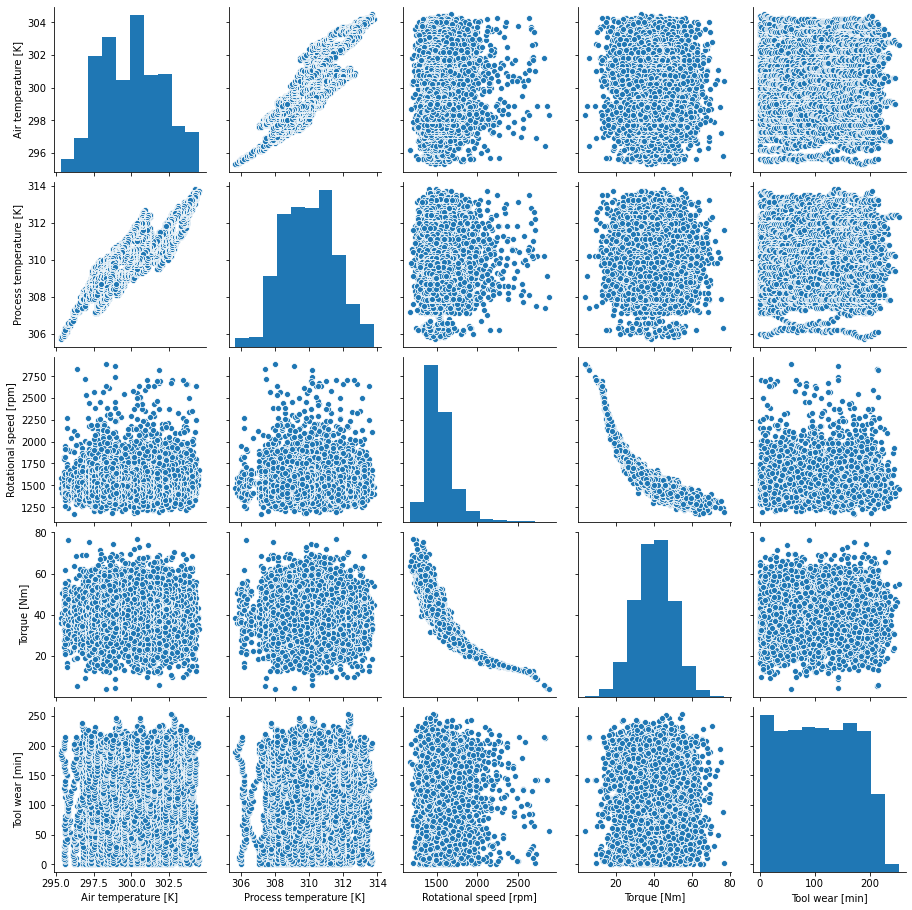

In [18]:
sns.pairplot(train_data[cols[3:8]])

Except for Rotational speed , the numeric variables have a near gaussian distribution.  
Process temparature and air temperature show linearity and positive correlation.
Torque and Rotational speed show linearity and negative correlation.  

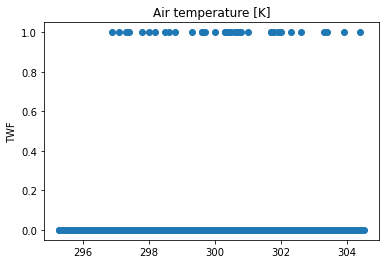

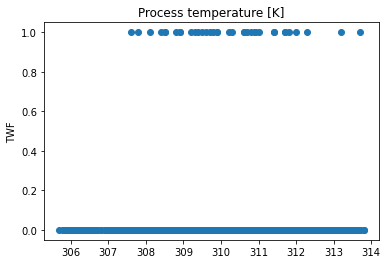

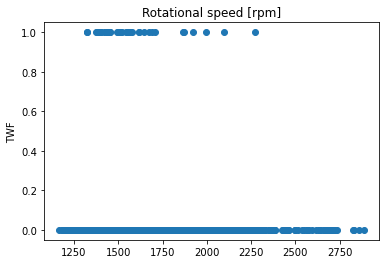

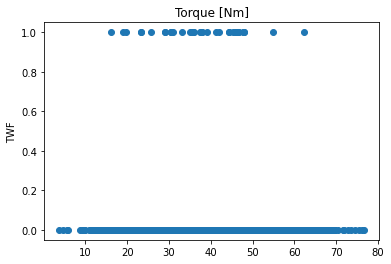

In [20]:
## Plot the failures against the predictor variables.
for i in range(3,7):
    plt.figure()
    plt.scatter(train_data[cols[i]], train_data['TWF'])
    plt.title(cols[i])
    plt.ylabel('TWF')

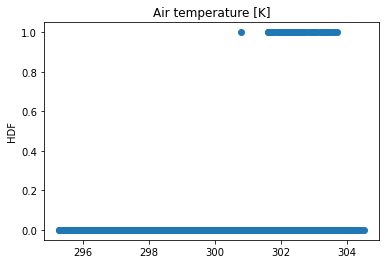

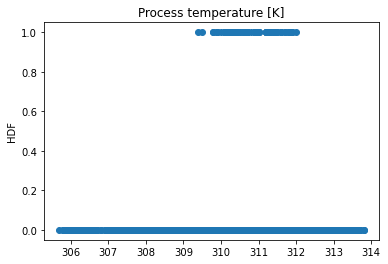

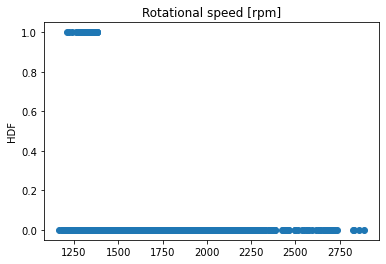

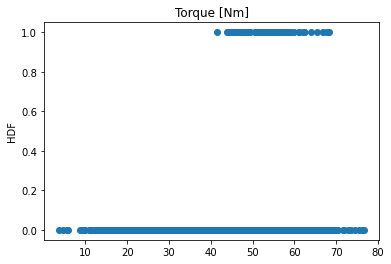

In [21]:
## Plot the failures against the predictor variables.
for i in range(3,7):
    plt.figure()
    plt.scatter(train_data[cols[i]], train_data['HDF'])
    plt.title(cols[i])
    plt.ylabel('HDF')

In [23]:
predictors = train_data[['Air temperature [K]','Rotational speed [rpm]','Tool wear [min]']]
X_test_1 = test_data_1[['Air temperature [K]','Rotational speed [rpm]','Tool wear [min]']]
y_test_1 = test_data_1['Machine failure']
target = train_data['Machine failure']
## Since the temparature variables are correlated and torque and rotational speed are too , include one of them in the model.

X_train, X_validation, y_train, y_validation = train_test_split(predictors, target , stratify = target , test_size = 0.15, random_state = 12)
print("Train data size :{}".format(X_train.shape))
print("Validation data size :{}".format(X_validation.shape))
print("Test data size :{}".format(X_test_1.shape))

Train data size :(6885, 3)
Validation data size :(1215, 3)
Test data size :(1000, 3)


In [24]:
y_train.value_counts()

0    6651
1     234
Name: Machine failure, dtype: int64

In [25]:
## Using SMOTE balance train data set 
oversample = imblearn.over_sampling.SMOTE(random_state = 3)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)


In [26]:
print("Oversampled train data :{}".format(X_train_resampled.shape))

Oversampled train data :(13302, 3)


In [27]:
print("Count of classes in oversampled data :{}".format(y_train_resampled.value_counts()))

Count of classes in oversampled data :1    6651
0    6651
Name: Machine failure, dtype: int64


In [28]:
X_train_resampled

,Air temperature [K],Rotational speed [rpm],Tool wear [min]
0,303.600000,2168,219
1,303.200000,1349,9
2,297.300000,1584,141
3,299.000000,1412,246
4,301.900000,1419,20
...,...,...,...
13297,295.785172,1371,215
13298,302.794575,1303,210
13299,302.435618,1356,101
13300,300.799465,1360,212


In [30]:
X_test_1

,Air temperature [K],Rotational speed [rpm],Tool wear [min]
5019,304.0,1466,83
5324,303.4,1526,37
8518,298.3,1681,194
3341,301.4,1329,160
6300,301.2,1517,107
...,...,...,...
6497,300.8,1312,192
4643,303.2,1324,228
4501,302.5,1307,86
4851,303.7,1363,90


In [31]:
y_train_resampled.value_counts()

1    6651
0    6651
Name: Machine failure, dtype: int64

In [32]:
y_validation.value_counts()

0    1174
1      41
Name: Machine failure, dtype: int64

In [34]:
y_test_1.value_counts()

0    966
1     34
Name: Machine failure, dtype: int64

In [35]:
## Scale the input variables
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test_1)

In [36]:
lg = LogisticRegression()
model = lg.fit(X_train_scaled,y_train_resampled)
train_pred = model.predict(X_train_scaled)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix for train data : \n")
print(confusion_matrix(y_train_resampled,train_pred))
print("Confusion matrix for validation data : \n")
print(confusion_matrix(y_validation,validation_pred))

Confusion matrix for train data : 

[[4255 2396]
 [2186 4465]]
Confusion matrix for validation data : 

[[772 402]
 [ 15  26]]


Confusion matrix : 

[[644 322]
 [ 10  24]]
Classification report : 

              precision    recall  f1-score   support

           0       0.98      0.67      0.80       966
           1       0.07      0.71      0.13        34

    accuracy                           0.67      1000
   macro avg       0.53      0.69      0.46      1000
weighted avg       0.95      0.67      0.77      1000



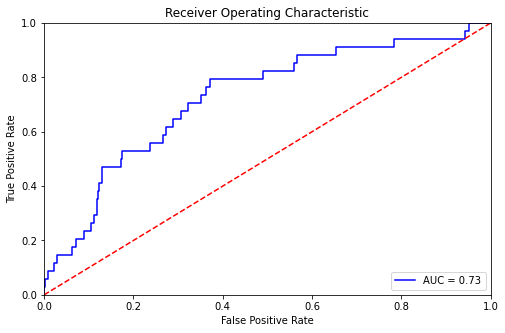

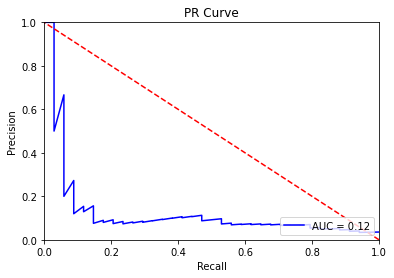

In [38]:
## On Test data 
## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [39]:
classifier  = ['Logistic Regression']
pr = [0.07]
rc = [0.71]
f1_score = [0.13]

Very poor performance on test data by logistic regression.  

In [40]:
predictors = train_data[cols[3:8]]
X_test_1 = test_data_1[cols[3:8]]
y_test_1 = test_data_1['Machine failure']
target = train_data['Machine failure']
## Since the temparature variables are correlated and torque and rotational speed are too , include one of them in the model.

X_train, X_validation, y_train, y_validation = train_test_split(predictors, target , stratify = target , test_size = 0.15, random_state = 12)
print("Train data size :{}".format(X_train.shape))
print("Validation data size :{}".format(X_validation.shape))
print("Test data size :{}".format(X_test_1.shape))

Train data size :(6885, 5)
Validation data size :(1215, 5)
Test data size :(1000, 5)


In [41]:
## Using SMOTE balance train data set 
oversample = imblearn.over_sampling.SMOTE(random_state = 3)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)
##
print("Oversampled train data :{}".format(X_train_resampled.shape))
##
print("Count of classes in oversampled data :{}".format(y_train_resampled.value_counts()))
##
## Scale the input variables
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test_1)

Oversampled train data :(13302, 5)
Count of classes in oversampled data :1    6651
0    6651
Name: Machine failure, dtype: int64


In [42]:
from sklearn.tree import DecisionTreeClassifier
#
dt = DecisionTreeClassifier(random_state = 12,class_weight = 'balanced')
#
model = dt.fit(X_train_scaled,y_train_resampled)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))


Confusion matrix : 

[[1107   67]
 [  16   25]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1174
           1       0.27      0.61      0.38        41

    accuracy                           0.93      1215
   macro avg       0.63      0.78      0.67      1215
weighted avg       0.96      0.93      0.94      1215



In [43]:
model.get_depth()

25

In [44]:
## feature importances
ft = model.feature_importances_

Text(0.5, 1.0, 'Feature Importance')

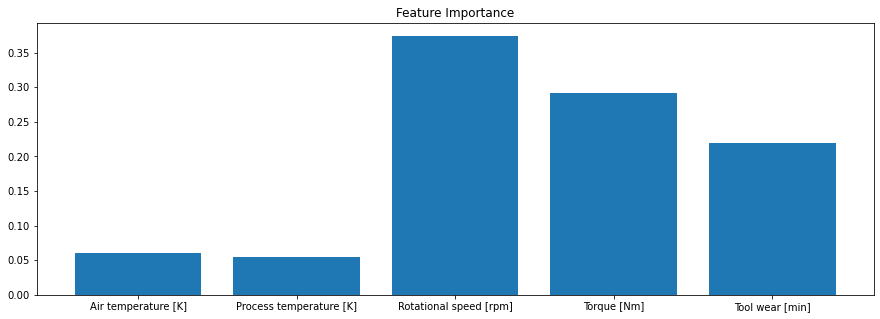

In [45]:
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("Feature Importance")

{'max_depth': 20, 'min_samples_split': 2}
Validation set score using predicted labels: 0.97
Calculated Validation set score: 0.93
Accuracy score :0.966
Confusion matrix :
[[1174    0]
 [  41    0]]


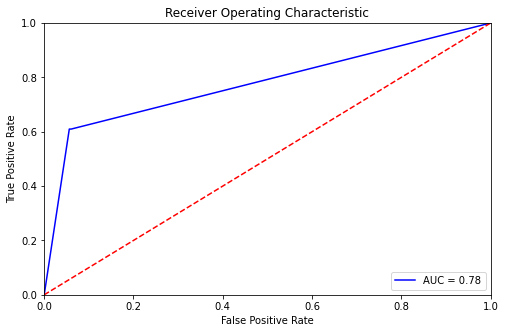

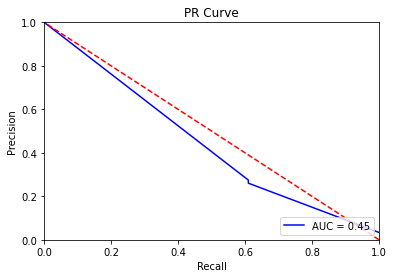

In [46]:
param_grid = {
    'max_depth' : [2,5,10,15,20],
    'min_samples_split' : [2,5,15],
    }

kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
dt = DecisionTreeClassifier(random_state = 111, class_weight = 'balanced')
grid_search = GridSearchCV(dt, param_grid, cv=kf, scoring = 'f1')
grid_search.fit(X_train_scaled, y_train_resampled)
#
print(grid_search.best_params_)
#
dt_best = grid_search.best_estimator_
dt_predictions = dt_best.predict(X_validation)
#
print("Validation set score using predicted labels: {:.2f}".format(np.mean(dt_predictions == y_validation)))

print("Calculated Validation set score: {:.2f}".format(dt_best.score(X_validation_scaled,y_validation)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validation,dt_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validation,dt_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = dt_best.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[1105   69]
 [  15   26]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1174
           1       0.27      0.63      0.38        41

    accuracy                           0.93      1215
   macro avg       0.63      0.79      0.67      1215
weighted avg       0.96      0.93      0.94      1215



Text(0.5, 1.0, 'DT Classifier Feature Importance')

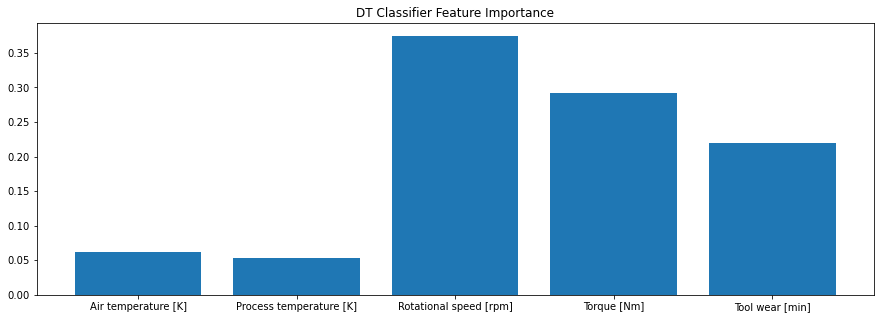

In [47]:
## DT with selected parameters 
dt = DecisionTreeClassifier(random_state = 12,class_weight = 'balanced', max_depth = 20 , min_samples_split = 2)
model = dt.fit(X_train_scaled,y_train_resampled)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation, validation_pred))
##
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("DT Classifier Feature Importance")

Confusion matrix : 

[[932  34]
 [ 12  22]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       966
           1       0.39      0.65      0.49        34

    accuracy                           0.95      1000
   macro avg       0.69      0.81      0.73      1000
weighted avg       0.97      0.95      0.96      1000



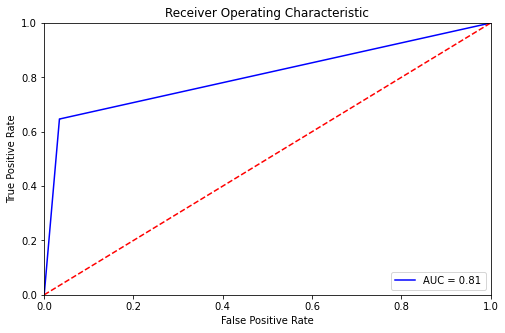

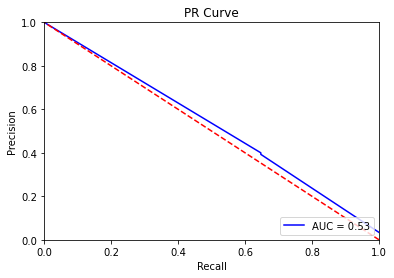

In [49]:
## On test data 
## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [50]:
classifier.append('DT')
pr.append(0.39)
rc.append(0.65)
f1_score.append(0.49)

[0.95934353 0.95535714 0.95583832 0.95897629 0.96577381]

 Avg AUC score for PR curve:0.9590578186632348


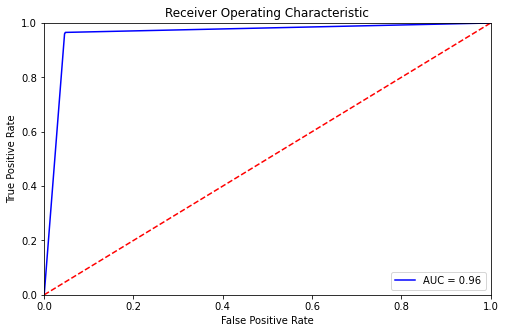

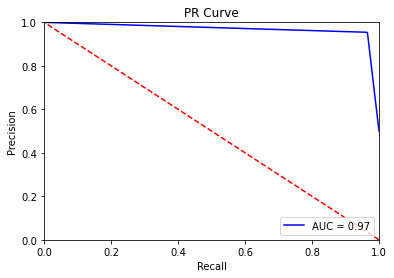

Confusion matrix : 

[[6335  316]
 [ 232 6419]]
Classification report : 

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      6651
           1       0.95      0.97      0.96      6651

    accuracy                           0.96     13302
   macro avg       0.96      0.96      0.96     13302
weighted avg       0.96      0.96      0.96     13302



In [51]:
## Cross Validation 
dt = DecisionTreeClassifier(random_state = 12,class_weight = 'balanced', max_depth = 20 , min_samples_split = 2)
##
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
scores = cross_val_score(dt , X_train_resampled , y_train_resampled , cv = kf,scoring = 'f1' )
print(scores)
print("\n Avg AUC score for PR curve:{}".format(scores.mean()))
##

predicted = cross_val_predict(dt,  X_train_resampled , y_train_resampled , cv = kf, method = 'predict_proba' )
fpr, tpr, thresholds = roc_curve(y_train_resampled , predicted[:,1])
roc_auc = auc(fpr, tpr)
##
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_train_resampled , predicted[:,1])
##



pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
##
predicted_class = cross_val_predict(dt,X_train_resampled,y_train_resampled , cv = kf )
print("Confusion matrix : \n")
print(confusion_matrix(y_train_resampled ,predicted_class))
print("Classification report : \n")
print(classification_report(y_train_resampled ,predicted_class))



In [52]:
## RandomForest Classifier 
from sklearn.ensemble import RandomForestClassifier
#
rf = RandomForestClassifier(random_state = 12,class_weight = 'balanced')
model = rf.fit(X_train_scaled,y_train_resampled)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))


Confusion matrix : 

[[1125   49]
 [  14   27]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1174
           1       0.36      0.66      0.46        41

    accuracy                           0.95      1215
   macro avg       0.67      0.81      0.72      1215
weighted avg       0.97      0.95      0.96      1215



Text(0.5, 1.0, 'RF Classifier Feature Importance')

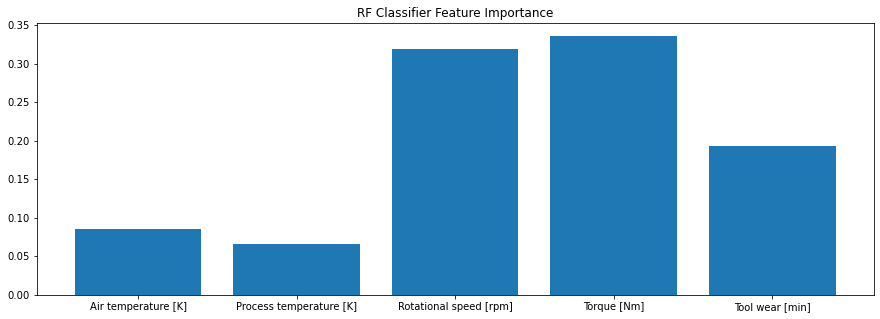

In [53]:
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("RF Classifier Feature Importance")

{'max_depth': 15, 'n_estimators': 800}
Validation set score using predicted labels: 0.93
Calculated Validation set score: 0.94
Accuracy score :0.928
Confusion matrix :
[[1103   71]
 [  16   25]]


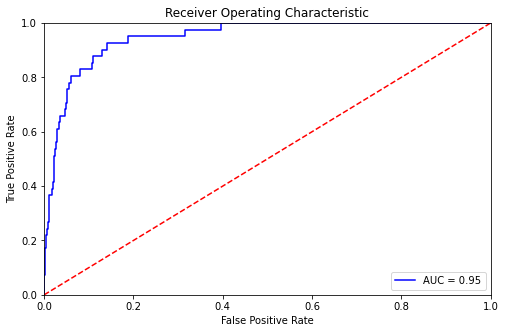

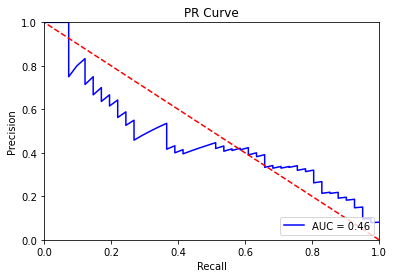

In [54]:
## GridSearchCV
param_grid = {
    'max_depth' : [2,5,10,15],
    'n_estimators' : [100,400,800],
    }
##
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
rf = RandomForestClassifier(random_state = 12,class_weight = 'balanced')
grid_search = GridSearchCV(rf, param_grid, cv=kf, scoring = 'f1')
grid_search.fit(X_train_scaled, y_train_resampled)
#
print(grid_search.best_params_)
#
rf_best = grid_search.best_estimator_
rf_predictions = dt_best.predict(X_validation_scaled)
#
print("Validation set score using predicted labels: {:.2f}".format(np.mean(rf_predictions == y_validation)))

print("Calculated Validation set score: {:.2f}".format(rf_best.score(X_validation_scaled,y_validation)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validation,rf_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validation,rf_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = rf_best.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[1120   54]
 [  13   28]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1174
           1       0.34      0.68      0.46        41

    accuracy                           0.94      1215
   macro avg       0.66      0.82      0.71      1215
weighted avg       0.97      0.94      0.95      1215



Text(0.5, 1.0, 'RF Classifier Feature Importance')

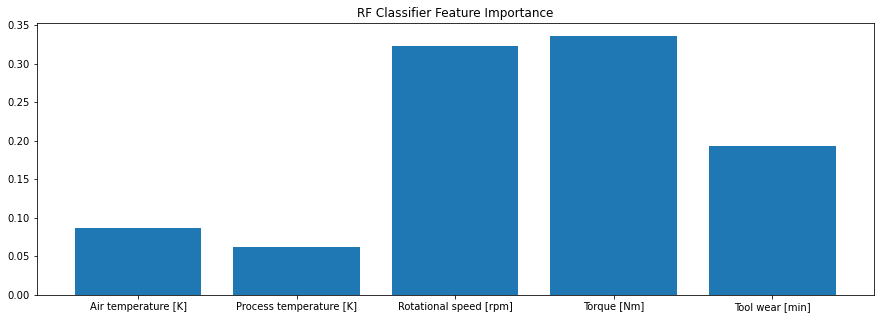

In [58]:
rf = RandomForestClassifier(random_state = 12,class_weight = 'balanced', max_depth = 15, n_estimators = 800)
model = rf.fit(X_train_scaled,y_train_resampled)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))
##
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("RF Classifier Feature Importance")

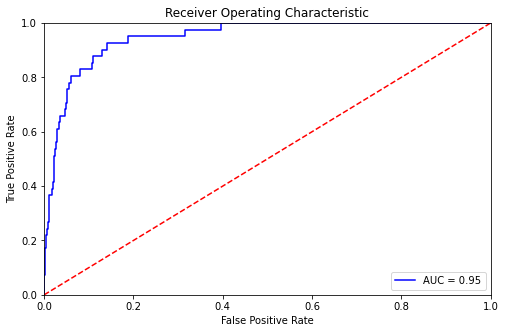

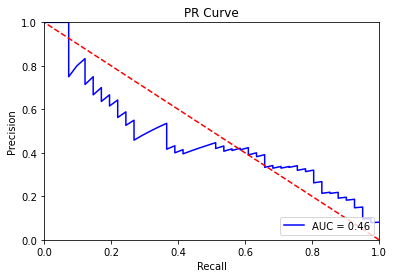

In [59]:
## Calculate the AUC and plot the ROC curve.
test_prob = model.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[934  32]
 [  3  31]]
Classification report : 

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       966
           1       0.49      0.91      0.64        34

    accuracy                           0.96      1000
   macro avg       0.74      0.94      0.81      1000
weighted avg       0.98      0.96      0.97      1000



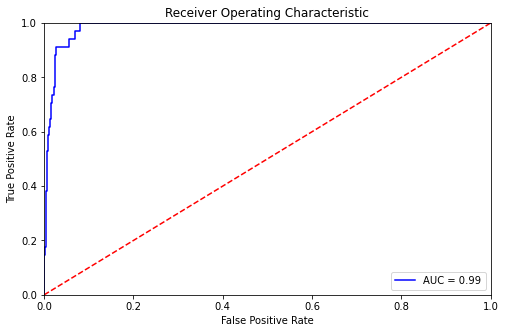

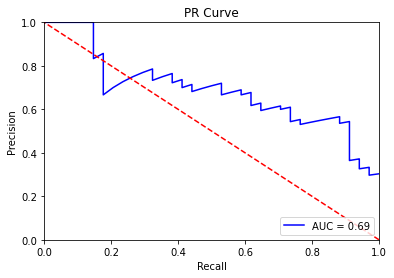

In [60]:
## on test data 

## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [61]:
classifier.append('RF')
pr.append(0.49)
rc.append(0.91)
f1_score.append(0.64)

[0.97405486 0.96992202 0.9710897  0.97586335 0.97225305]

 Avg AUC score for PR curve:0.9726365946320653


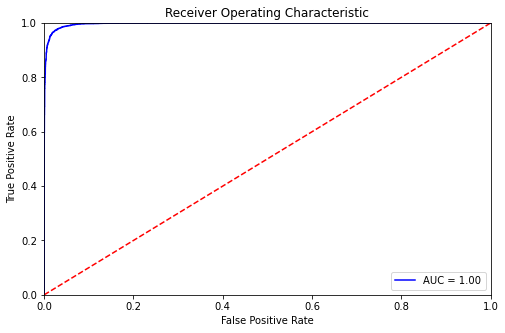

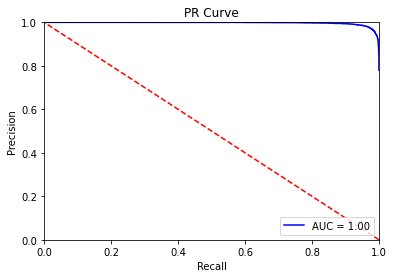

Confusion matrix : 

[[6375  276]
 [  93 6558]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      6651
           1       0.96      0.99      0.97      6651

    accuracy                           0.97     13302
   macro avg       0.97      0.97      0.97     13302
weighted avg       0.97      0.97      0.97     13302



In [62]:
## Cross Validation 
rf = RandomForestClassifier(random_state = 12,class_weight = 'balanced', max_depth = 15, n_estimators = 800)
##
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
scores = cross_val_score(rf , X_train_resampled , y_train_resampled , cv = kf,scoring = 'f1' )
print(scores)
print("\n Avg AUC score for PR curve:{}".format(scores.mean()))
##

predicted = cross_val_predict(rf,  X_train_resampled , y_train_resampled , cv = kf, method = 'predict_proba' )
fpr, tpr, thresholds = roc_curve(y_train_resampled , predicted[:,1])
roc_auc = auc(fpr, tpr)
##
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_train_resampled , predicted[:,1])
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
#
predicted_class = cross_val_predict(rf,X_train_resampled,y_train_resampled , cv = kf )
print("Confusion matrix : \n")
print(confusion_matrix(y_train_resampled ,predicted_class))
print("Classification report : \n")
print(classification_report(y_train_resampled ,predicted_class))

In [63]:
## Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

Confusion matrix : 

[[1095   79]
 [   7   34]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1174
           1       0.30      0.83      0.44        41

    accuracy                           0.93      1215
   macro avg       0.65      0.88      0.70      1215
weighted avg       0.97      0.93      0.94      1215



Text(0.5, 1.0, 'GBM Classifier Feature Importance')

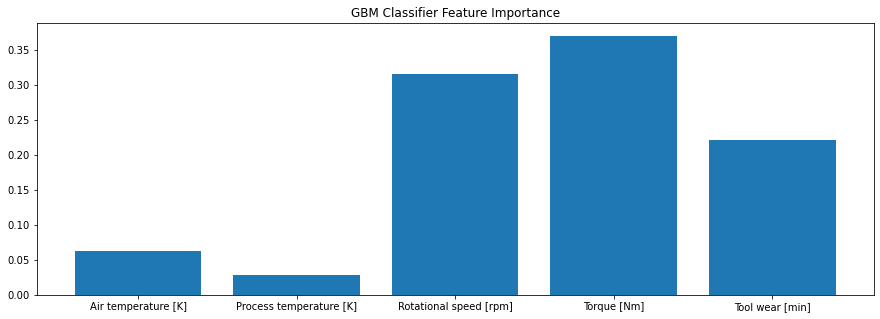

In [64]:
gbm = GradientBoostingClassifier(random_state = 123)
model = gbm.fit(X_train_scaled,y_train_resampled)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))
##
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("GBM Classifier Feature Importance")

{'learning_rate': 1, 'n_estimators': 800}
Test set score using predicted labels: 0.97
Calculated Test set score: 0.97
Accuracy score :0.968
Confusion matrix :
[[1154   20]
 [  19   22]]


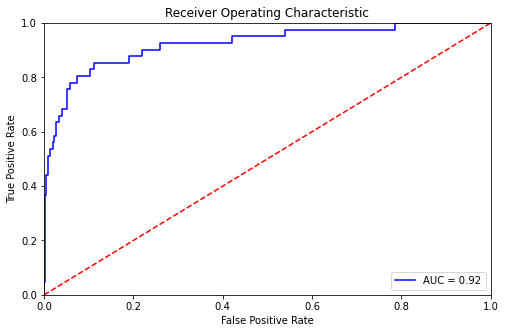

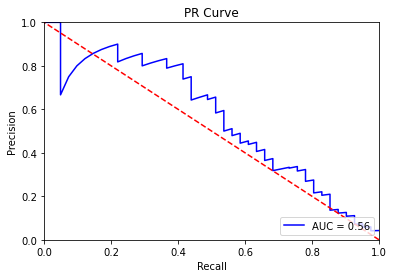

In [65]:
## Hyper parameter tuning

param_grid = {
    'learning_rate' : [0.01, 0.1,1],
    'n_estimators' : [100,400,800],
    }
gbm = GradientBoostingClassifier(random_state = 111)
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
grid_search = GridSearchCV(gbm, param_grid, cv=kf, scoring = 'f1')
grid_search.fit(X_train_scaled, y_train_resampled)
#
print(grid_search.best_params_)
#
gbm_best = grid_search.best_estimator_
gbm_predictions = gbm_best.predict(X_validation_scaled)
#
print("Test set score using predicted labels: {:.2f}".format(np.mean(gbm_predictions == y_validation)))

print("Calculated Test set score: {:.2f}".format(gbm_best.score(X_validation_scaled,y_validation)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validation,gbm_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validation,gbm_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = gbm_best.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[1154   20]
 [  19   22]]
Classification report : 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1174
           1       0.52      0.54      0.53        41

    accuracy                           0.97      1215
   macro avg       0.75      0.76      0.76      1215
weighted avg       0.97      0.97      0.97      1215



Text(0.5, 1.0, 'GBM Classifier Feature Importance')

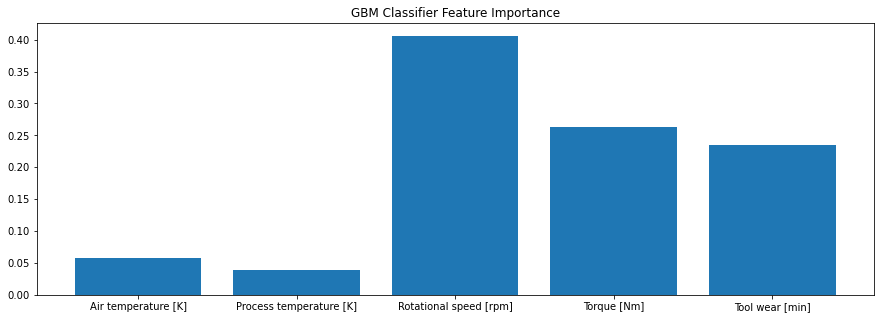

In [66]:
gbm = GradientBoostingClassifier(random_state = 123, learning_rate = 1 , n_estimators = 800)
model = gbm.fit(X_train_scaled,y_train_resampled)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))
##
## feature importances
ft = model.feature_importances_
plt.figure(figsize = (15,5))
plt.bar(cols[3:8], ft)
plt.title("GBM Classifier Feature Importance")

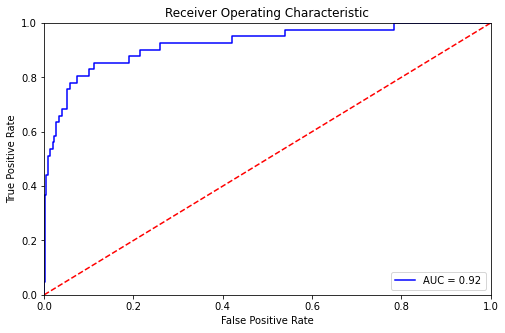

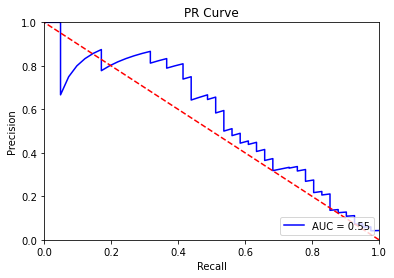

In [67]:
## Calculate the AUC and plot the ROC curve.
test_prob = model.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix for test data : 

[[959   7]
 [  9  25]]
Classification report for test data : 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.78      0.74      0.76        34

    accuracy                           0.98      1000
   macro avg       0.89      0.86      0.87      1000
weighted avg       0.98      0.98      0.98      1000



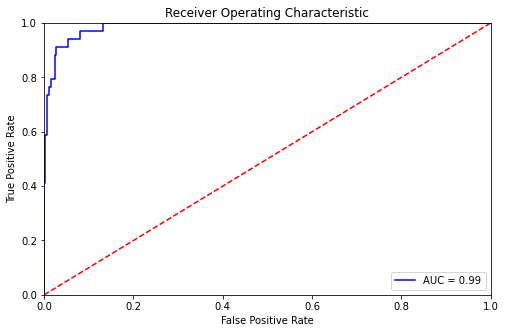

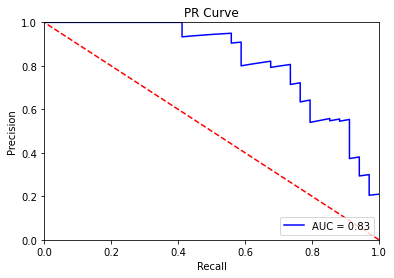

In [68]:
## on test data 
## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix for test data : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report for test data : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [69]:
classifier.append('GBC')
pr.append(0.78)
rc.append(0.74)
f1_score.append(0.76)

[0.98608499 0.98348348 0.98653702 0.98835024 0.99176647]

 Avg AUC score for PR curve:0.9872444424726886


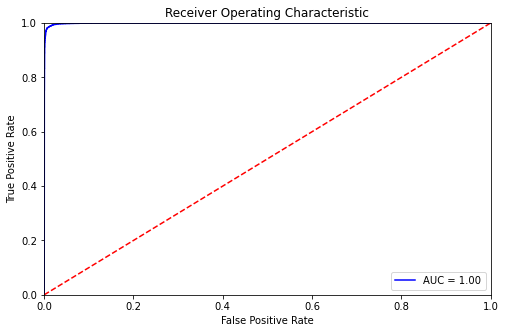

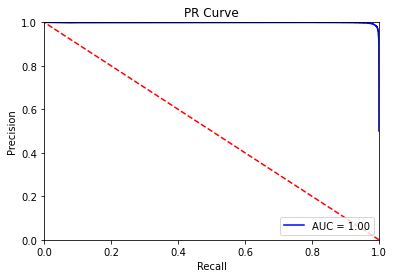

Confusion matrix : 

[[6552   99]
 [  71 6580]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6651
           1       0.99      0.99      0.99      6651

    accuracy                           0.99     13302
   macro avg       0.99      0.99      0.99     13302
weighted avg       0.99      0.99      0.99     13302



In [76]:
## Cross Validation 
gbm = GradientBoostingClassifier(random_state = 123, learning_rate = 1 , n_estimators = 800)
##
kf = StratifiedKFold(n_splits = 5 , shuffle = True, random_state = 33)
scores = cross_val_score(gbm , X_train_resampled , y_train_resampled , cv = kf,scoring = 'f1' )
print(scores)
print("\n Avg AUC score for PR curve:{}".format(scores.mean()))
##

predicted = cross_val_predict(gbm, X_train_resampled , y_train_resampled , cv = kf, method = 'predict_proba' )
fpr, tpr, thresholds = roc_curve(y_train_resampled, predicted[:,1])
roc_auc = auc(fpr, tpr)
##
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_train_resampled, predicted[:,1])
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
##
predicted_class = cross_val_predict(gbm,X_train_resampled,y_train_resampled , cv = kf )
print("Confusion matrix : \n")
print(confusion_matrix(y_train_resampled ,predicted_class))
print("Classification report : \n")
print(classification_report(y_train_resampled ,predicted_class))


{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
Test set score using predicted labels: 0.82
Calculated Test set score: 0.82
Accuracy score :0.819
Confusion matrix :
[[963 211]
 [  9  32]]


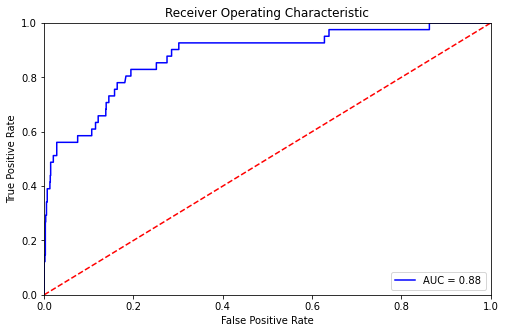

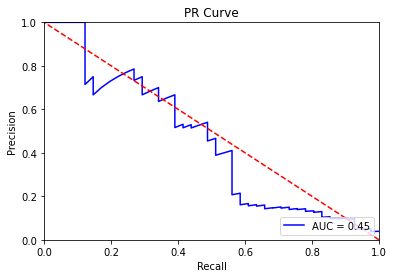

In [71]:
from sklearn.svm import SVC
param_grid = {
    'C' : [0.01,0.1,1],
    'kernel' : ['linear'],
    'gamma' : ['auto']
    }
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 33)
svm = SVC(random_state = 111, class_weight = 'balanced', probability = True )
grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring = 'f1')
grid_search.fit(X_train_scaled, y_train_resampled)
#
print(grid_search.best_params_)
#
svm_best = grid_search.best_estimator_
svm_predictions = svm_best.predict(X_validation_scaled)
#
print("Test set score using predicted labels: {:.2f}".format(np.mean(svm_predictions == y_validation)))

print("Calculated Test set score: {:.2f}".format(svm_best.score(X_validation_scaled,y_validation)))

print("Accuracy score :{:.3f}".format(accuracy_score(y_validation,svm_predictions)))

print("Confusion matrix :\n{}".format(confusion_matrix(y_validation,svm_predictions)))
##
## Calculate the AUC and plot the ROC curve.
test_prob = svm_best.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix : 

[[963 211]
 [  9  32]]
Classification report : 

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1174
           1       0.13      0.78      0.23        41

    accuracy                           0.82      1215
   macro avg       0.56      0.80      0.56      1215
weighted avg       0.96      0.82      0.87      1215



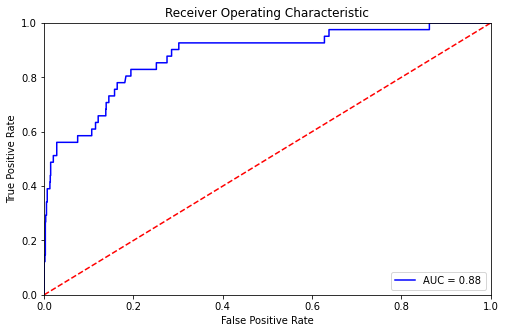

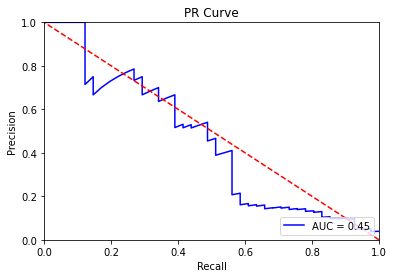

In [72]:
svm = SVC(random_state = 123, C = 1, gamma = 'auto', kernel = 'linear',class_weight = 'balanced', probability = True)
model = svm.fit(X_train_scaled,y_train_resampled)
validation_pred = model.predict(X_validation_scaled)
print("Confusion matrix : \n")
print(confusion_matrix(y_validation,validation_pred))
print("Classification report : \n")
print(classification_report(y_validation,validation_pred))
##
## Calculate the AUC and plot the ROC curve.
test_prob = model.predict_proba(X_validation_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_validation, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_validation, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Confusion matrix for test data : 

[[813 153]
 [  5  29]]
Classification report for test data : 

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       966
           1       0.16      0.85      0.27        34

    accuracy                           0.84      1000
   macro avg       0.58      0.85      0.59      1000
weighted avg       0.97      0.84      0.89      1000



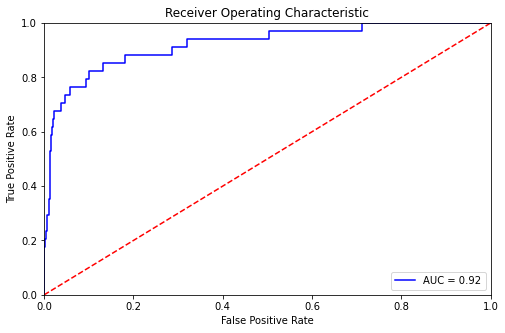

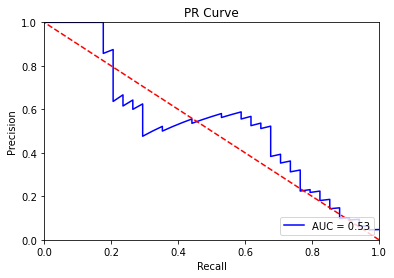

In [73]:
## on test data 
## Calculate the AUC and plot the ROC curve.
test_pred = model.predict(X_test_scaled)
print("Confusion matrix for test data : \n")
print(confusion_matrix(y_test_1,test_pred))
print("Classification report for test data : \n")
print(classification_report(y_test_1,test_pred))
test_prob = model.predict_proba(X_test_scaled)
preds = test_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, preds)
roc_auc = auc(fpr, tpr)
    
## Plot ROC curve.
plt.figure(figsize = (8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##Calculate AUC and plot precision recall curve.
precision, recall, thresholds = precision_recall_curve(y_test_1, preds)
pr_auc = auc(recall, precision)
    
## Plot PR curve.
plt.title('PR Curve')
plt.plot( recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
plt.plot([1, 0], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [74]:
classifier.append('SVC')
pr.append(0.16)
rc.append(0.85)
f1_score.append(0.27)

SVC Classifier has performed poorly for class 1 as precision is very poor.       

In [75]:
results = {}
results['classifier'] = classifier
results['pr'] = pr
results['recall'] = rc
results['f1_score'] = f1_score
results_df = pd.DataFrame(results)
results_df.set_index('classifier', inplace = True)

In [76]:
results_df

,pr,recall,f1_score
classifier,,,
Logistic Regression,0.07,0.71,0.13
DT,0.44,0.79,0.56
RF,0.51,0.91,0.65
GBC,0.78,0.74,0.76
SVC,0.16,0.85,0.26


 Summary :  

GBM Classifier has performed the best with oversampling training data using  SMOTE achieving balanced train dataset.    
9 out of 34 are misclassified as 'non failure' and 7 out of 966 are mis-classified as 'failure'.  
Rotational speed and Torque are the most important features that help the RF model in classifying failures.  

By increasing the sampling strategy to make completely balanced train data set, there is  no incremental performance enhancement on classification task .    

In [79]:
## Save the GBM Classifier model 
gbm = GradientBoostingClassifier(random_state = 123, learning_rate = 1 , n_estimators = 800)
model = gbm.fit(X_train_scaled,y_train_resampled)


In [80]:
## save the model 
pickle.dump(model, open('pm_ai2020_model_2.sav' , 'wb'))

In [82]:
## GBM Classifier on unscaled data  
gbm = GradientBoostingClassifier(random_state = 123, learning_rate = 1 , n_estimators = 800)
model_2 = gbm.fit(X_train_resampled,y_train_resampled)


In [83]:
## save the model 
pickle.dump(model_2, open('pm_ai2020_model_3.sav' , 'wb'))